# Diffusion in 2D

ME469 - Computational Methods in Fluid Dynamics - Stanford University

Example #4

These examples are provided as part of the ME469 class (Spring 2018).

For comments or corrections, please contact jops at stanford dot edu

## Objective
Study the convergence rate of the solution to the steady diffusion equation using different a finite volume scheme.

We wish to solve the diffusive transport of a contaminant $\phi$ in a closed space. The mathematical model chosen is the steady 2D diffusion equation with a source term.

$$ \int_S \gamma \left( \vec{\nabla}\phi \cdot \vec{n}  \right) dS = \int_V b dV $$

where $S$ is the surface of the control volume, $V$ its volume and $\gamma$ is the diffusion coefficient. The source term $b$ is also known. boundary conditions are specified as Dirichlet on all boundaries.

In [221]:
#set things up
import numpy  as np                       
import pylab as pl
import time, sys  
%matplotlib inline 

### Let's get started
Set physical and numerical parameters for the problem, and define a suitable initiation condition

In [231]:
gamma = 0.01     # diffusion coefficient [m^2/s]
L_x = 3.0        # length of the domain   [m]
L_y = 3.0        # length of the domain   [m]
p = 10.0         # polynomial order to describe the exact, reference solution

We assume that the exact solution is expressed as a polynomial of order $p$ and consequently compute the source term $b$. 

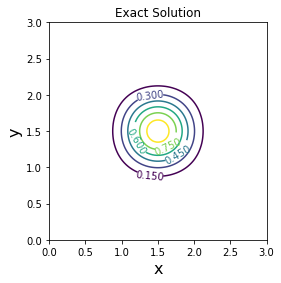

In [232]:
# define initial condition   
def ic(x,y):
    # initial distribution is linear 
    #phi_ic = x*y
    phi_ic=exact(x,y)
    return phi_ic


# define the exact solution
def exact(x,y,return_source="no"):
    phi_exact = (2.0**(4.0*p)/(L_x**(2.0*p))/(L_y**(2.0*p)))*(x**p)*((L_x-x)**p)*(y**p)*((L_y-y)**p)
    pm1 = p-1.0
    pm2 = p-2.0
    b_exact =(  
              ( gamma * (2.0**(4.0*p)/(L_x**(2.0*p))/(L_y**(2.0*p))) *
              ( (p-1)*p * (x**pm2) * ((L_x-x)**pm2) * ((L_x - x)**2 + x**2 ) 
              -  2.0*(p**2) * (x**pm1) * ((L_x - x)**pm1)) * (y**p)*((L_y-y)**p) ) +
              ( gamma * (2.0**(4.0*p)/(L_x**(2.0*p))/(L_y**(2.0*p))) *
              ( (p-1)*p * (y**pm2) * ((L_y-y)**pm2) * ((L_y - y)**2 + y**2 ) 
              -  2.0*(p**2) * (y**pm1) * ((L_y - y)**pm1)) * (x**p)*((L_x-x)**p) ))
    # the function returns either the exact solution of its second derivative (source term)
    if return_source == "no": 
        return_value = phi_exact
    else:
        return_value = b_exact
    return return_value

# plot the exact solution  to check that is what you expect...
def exact_plot():
    x = np.linspace(0,L_x,100)
    y = np.linspace(0,L_y,100)
    phi = np.zeros((100, 100)) #initialize, careful with the indices...
    for j in range(100):
        for i in range(100):
            phi[j,i]=exact(x[i],y[j],return_source="no")
    pl.clf()
    # make sure axis have labels  
    X, Y = np.meshgrid(x, y)
    pl.figure()
    CS = pl.contour(X, Y, phi)
    pl.gca().set_aspect('equal')
    pl.clabel(CS, inline=1)
    pl.xlabel("x",fontsize=16) 
    pl.ylabel("y",fontsize=16)  
    pl.title('Exact Solution')
    
exact_plot()

Some utility functions that will be useful later

In [233]:
# set initial condition   
def initialize(ncv_x,ncv_y,xc,yc,phi):
    for jcv in range(ncv_y):
        for icv in range(ncv_x):
            #phi[jcv,icv]=xc[icv]*yc[jcv]
            phi[jcv,icv]=ic(xc[icv],yc[jcv])

# generate the grid
def generate_grid(ncv_x,ncv_y,nno_x,nno_y,x,y,xc,yc):
    dx = L_x / (float)(ncv_x)    # spacing of the nodes
    dy = L_y / (float)(ncv_y)    
    
    for ino in range(nno_x):
        x[ino] = L_x*(float)(ino)/(float)(nno_x-1)
    for jno in range(nno_y):
        y[jno] = L_y*(float)(jno)/(float)(nno_y-1)
            
    for icv in range(ncv_x): 
        ino_east = icv+1
        ino_west = icv
        xc[icv] = 0.5*(x[ino_west]+x[ino_east]) 
    for jcv in range(ncv_y): 
        jno_north = jcv+1
        jno_south = jcv
        yc[jcv] = 0.5*(y[jno_north]+y[jno_south]) 
    return dx, dy
     
# compute exact solution
def compute_exact(ncv_x,ncv_y,xc,yc,phi_exact):
    for jcv in range(ncv_y):
        for icv in range(ncv_x):
            phi_exact[jcv,icv]=exact(xc[icv],yc[jcv])  # assume only diffusion...
            
# plot the solution and compare to the exact one
def plot_solution(ncv_x,ncv_y,xc,yc,phi,phi_exact):
    
    X, Y = np.meshgrid(xc, yc)
    pl.figure()
    CS = pl.contour(X, Y, phi)
    pl.clabel(CS, inline=1)
    pl.gca().set_aspect('equal')
    pl.xlabel("x",fontsize=16) 
    pl.ylabel("y",fontsize=16)  
    pl.title('Computed Solution')
    
# compute the L2 norm of the error
def compute_error(ncv_x,ncv_y,dx,dy,phi,phi_exact):   
    error = np.zeros((ncv_y,ncv_x)) #initialize
    for jcv in range(ncv_y):
        for icv in range(ncv_x):
            error[jcv,icv]=(phi[jcv,icv]-phi_exact[jcv,icv])
    my_norm = np.sqrt(dx*dy*np.sum(error[1:ncv_y-1,1:ncv_x-1]**2))     
    return my_norm

## Linear System Solver

Implicit schemes require a linear system solver. In 2D the discretization leads to a pentadiagonal system. The matrix of coefficient is stored in terms of diagonals

$$ A_{north} \phi_{north} + A_{east} \phi_{east}  + A_{p} \phi_{icv}  + A_{west} \phi_{west} + A_{south} \phi_{south}   = b_{icv} $$

Two solvers are implemented, the standard Gauss-Seidel and the ILU solver (Stone method).

In [234]:
# solve a linear system using gauss-seidel
def solve_gs(ncv_x,ncv_y,dx,dy,phi,a_east,a_west,a_north,a_south,a_p,b,n_iter,tolerance):
    
    res = np.zeros((ncv_y,ncv_x)) #initialize

    for n in range(n_iter):
        # update solution - internal cells
        for jcv in range(ncv_y):
            jcv_north = min(jcv+1,ncv_y-1)  # assumes a_north[ncv_y-1,icv]=0
            jcv_south = max(jcv-1,0)        # assumes a_south[0,icv]=0
            for icv in range(ncv_x):
                icv_east = min(icv+1,ncv_x-1)   # assumes a_east[jcv,ncv_x-1]=0
                icv_west = max(icv-1,0)         # assumes a_west[jcv,0]=0
                phi[jcv,icv]=(b[jcv,icv]
                          -a_east [jcv,icv]*phi[jcv,icv_east ]-a_west [jcv,icv]*phi[jcv,icv_west ] 
                          -a_north[jcv,icv]*phi[jcv_north,icv]-a_south[jcv,icv]*phi[jcv_south,icv])/a_p[jcv,icv]
                
        for jcv in range(ncv_y):
            jcv_north = min(jcv+1,ncv_y-1)  # assumes a_north[ncv_y-1,icv]=0
            icv_south = max(jcv-1,0)        # assumes a_south[0,icv]=0
            for icv in range(ncv_x):
                icv_east = min(icv+1,ncv_x-1)   # assumes a_east[jcv,ncv_x-1]=0
                icv_west = max(icv-1,0)         # assumes a_west[jcv,0]=0
                res[jcv,icv] = (b[jcv,icv]
                        -a_east [jcv,icv]*phi[jcv,icv_east ]-a_west [jcv,icv]*phi[jcv,icv_west ]
                        -a_north[jcv,icv]*phi[jcv_north,icv]-a_south[jcv,icv]*phi[jcv_south,icv]
                        -a_p[jcv,icv]*phi[jcv,icv])
                residual = np.sqrt(dx*dy*np.sum(res[0:ncv_y,0:ncv_x]**2))                     
        if (n == 0):
            residual0 = residual
        if residual/residual0 < tolerance:
            break
    print "Completed Gauss-Seidel Iteration ",n,"Residual ",residual/residual0


# solve a linear system using ILU
def solve_ilu(ncv_x,ncv_y,dx,dy,phi,a_east,a_west,a_north,a_south,a_p,b,n_iter,tolerance):
    small = 1.0E-8
    alpha = 0.92 #under-relation factor...
    l_west  = np.zeros((ncv_y,ncv_x))
    l_south = np.zeros((ncv_y,ncv_x))
    l_p     = np.zeros((ncv_y,ncv_x))
    u_north = np.zeros((ncv_y,ncv_x))
    u_east  = np.zeros((ncv_y,ncv_x))
    res     = np.zeros((ncv_y,ncv_x))             
     
    # compute L/U coefficients
    
    for jcv in range(ncv_y):
        jcv_south = max(jcv-1,0) 
        for icv in range(ncv_x):
            icv_west = max(icv-1,0)         # assumes u_north[jcv,0]=0, a_west[jcv,0]=0 
            l_west [jcv,icv] = a_west [jcv,icv]/(1.+alpha*u_north[jcv,icv_west])
            l_south[jcv,icv] = a_south[jcv,icv]/(1.+alpha*u_east [jcv_south,icv] )
            p1 = alpha*l_west [jcv,icv]*u_north[jcv,icv_west]
            p2 = alpha*l_south[jcv,icv]*u_east [jcv_south,icv]            
            l_p [jcv,icv]    = (a_p[jcv,icv]+p1+p2 -l_west [jcv,icv]*u_east [jcv,icv_west]
                                                   -l_south[jcv,icv]*u_north[jcv_south,icv] )
            u_north[jcv,icv] = (a_north[jcv,icv]-p1)/(l_p[jcv,icv]+small)
            u_east [jcv,icv] = (a_east [jcv,icv]-p2)/(l_p[jcv,icv]+small)
    
    for n in range(n_iter):

        # compute residual
        residual = 0.0
        for jcv in range(ncv_y):
            jcv_north = min(jcv+1,ncv_y-1)  # assumes a_north[ncv_y-1,icv]=0
            jcv_south = max(jcv-1,0)        # assumes a_south[0,icv]=0
            for icv in range(ncv_x):
                icv_east = min(icv+1,ncv_x-1)   # assumes a_east[jcv,ncv_x-1]=0
                icv_west = max(icv-1,0)         # assumes a_west[jcv,0]=0
                res[jcv,icv]=(b[jcv,icv]
                            -a_east [jcv,icv]*phi[jcv,icv_east ]-a_west [jcv,icv]*phi[jcv,icv_west ]
                            -a_north[jcv,icv]*phi[jcv_north,icv]-a_south[jcv,icv]*phi[jcv_south,icv]
                            -a_p[jcv,icv]*phi[jcv,icv])
                residual=residual+res[jcv,icv]*res[jcv,icv]
                
                res[jcv,icv]=(res[jcv,icv]-l_south[jcv,icv]*res[jcv_south,icv]
                                          -l_west [jcv,icv]*res[jcv,icv_west] )/(l_p[jcv,icv]+small)  
    
        residual = np.sqrt(dx*dy*residual)
        if (n == 0):
            residual0 = residual
        
        # back-substitution
        for jcv in range(ncv_y-1,-1,-1):
            jcv_north = min(jcv+1,ncv_y-1)  # assumes a_north[ncv_y-1,icv]=0
            for icv in range(ncv_x-1,-1,-1):
                icv_east = min(icv+1,ncv_x-1)   # assumes a_east[jcv,ncv_x-1]=0
                res[jcv,icv]=res[jcv,icv]-u_north[jcv,icv]*res[jcv_north,icv]-u_east[jcv,icv]*res[jcv,icv_east]
                phi[jcv,icv]=phi[jcv,icv]+res[jcv,icv]
                
        #print "It",n,"residual",residual        
        if residual/residual0 < tolerance:
            break
    print "Completed ILU Iteration ",n,"Residual ",residual/residual0

## The discretization stencil
Define the discretization schemes - implicit finite volume stencils in the form:

$$ A_{north} \phi_{north}  + A_{east} \phi_{east} + A_{p} \phi_{icv} + A_{west} \phi_{west} + A_{south} \phi_{south} = b_{icv} $$

where $A_{east/west/north/south}$ correspond to the diffusive fluxes. Flux conservation guarantees that $A_p = - (A_{north} + A_{east}+ A_{west} + A_{south})$.

Note that the boundary conditions and the source term are specified directly in terms of the exact solution.

In [235]:
def fill_matrix(ncv_x,ncv_y,nno_x,nno_y,a_east,a_west,a_north,a_south,a_p,b,x,y,xc,yc,scheme="central"):

    # first the vertical faces...
    for jcv in range(ncv_y):
        
        # compute surface areas
        jno_north = jcv+1
        jno_south = jcv
        S_east = y[jno_north] - y[jno_south]
        S_west = y[jno_north] - y[jno_south]
        
        # west boundaries
        icv = 0
        ino_west = icv
        a_east [jcv,icv] = gamma/(xc[icv+1]-xc[icv])   * S_east
        a_west_tmp       = gamma/(xc[icv]-x[ino_west]) * S_west
        a_west [jcv,icv] = 0.0
        a_p    [jcv,icv] = -( a_east [jcv,icv] + a_west_tmp)
        b      [jcv,icv] = -a_west_tmp * exact(x[ino_west],yc[jcv])
               
        # internal cells
        for icv in range (1,ncv_x-1):
            a_east [jcv,icv] = gamma/(xc[icv+1]-xc[icv]) * S_east
            a_west [jcv,icv] = gamma/(xc[icv]-xc[icv-1]) * S_west
            a_p    [jcv,icv] = -( a_east [jcv,icv] + a_west [jcv,icv] )
            b      [jcv,icv] = 0.0
        
        # east boundary
        icv=ncv_x-1
        ino_east = icv+1
        a_east_tmp       = gamma/(x[ino_east]-xc[icv]) * S_east
        a_east [jcv,icv] = 0.0
        a_west [jcv,icv] = gamma/(xc[icv]-xc[icv-1])   * S_west
        a_p    [jcv,icv] = -( a_west [jcv,icv] + a_east_tmp)
        b      [jcv,icv] = -a_east_tmp * exact(x[ino_east],yc[jcv])
        
         
    # now the horizontal ones
    for icv in range (ncv_x):
        
        # compute surface areas
        ino_east = icv+1
        ino_west = icv
        S_north = x[ino_east]-x[ino_west]
        S_south = x[ino_east]-x[ino_west]
                
        # south boundary
        jcv = 0
        jno_south = jcv
        a_north[jcv,icv] = gamma/(yc[jcv+1]-yc[jcv])     * S_north
        a_south_tmp      = gamma/(yc[jcv]-y[jno_south])  * S_south
        a_south[jcv,icv] = 0.0
        b      [jcv,icv] = b  [jcv,icv] - a_south_tmp * exact(xc[icv],y[jno_south])
        a_p    [jcv,icv] = a_p[jcv,icv] - (  a_north[jcv,icv] + a_south_tmp )

     
        # internal cells
        for jcv in range (1,ncv_y-1):
            a_north[jcv,icv] = gamma/(yc[jcv+1]-yc[jcv]) * S_north
            a_south[jcv,icv] = gamma/(yc[jcv]-yc[jcv-1]) * S_south
            a_p    [jcv,icv] = a_p[jcv,icv] - ( a_north[jcv,icv] + a_south[jcv,icv] ) 
            
        # north boundary
        jcv=ncv_y-1
        jno_north = jcv+1
        a_north_tmp      = gamma/(y[jno_north]-yc[jcv]) * S_north
        a_south[jcv,icv] = gamma/(yc[jcv]-yc[jcv-1])    * S_south
        a_north[jcv,icv] = 0.0
        b      [jcv,icv] = b  [jcv,icv] - a_north_tmp * exact(xc[icv],y[jno_north]) 
        a_p    [jcv,icv] = a_p[jcv,icv] - ( a_south[jcv,icv] + a_north_tmp )

    # source term for the Poisson equation
    for jcv in range(ncv_y):
        jno_north = jcv+1
        jno_south = jcv
        for icv in range (ncv_x):
            ino_east = icv+1
            ino_west = icv
            volume = (x[ino_east]-x[ino_west])*(y[jno_north] - y[jno_south])
            b[jcv,icv] = b[jcv,icv] + exact(xc[icv],yc[jcv],return_source="yes")*volume
 

Solution step

In [236]:

            
# solve the PDE
def solve(ncv_x,ncv_y,scheme="central",solver="gs",plot=1):  
    
    nno_x = ncv_x+1        # number of nodes
    nno_y = ncv_y+1        # number of nodes

    x = np.zeros(nno_x)    # node coordinates!
    y = np.zeros(nno_y)   
    xc = np.zeros(ncv_x)   # control volume centroid
    yc = np.zeros(ncv_y) 
    
    dx,dy = generate_grid(ncv_x,ncv_y,nno_x,nno_y,x,y,xc,yc)
    
    #print "dx,dy",dx,dy
    #print "x",x,"y",y
    #print "xc",xc,"yc",yc
    
    phi = np.zeros((ncv_y,ncv_x)) 
    phi_exact = np.zeros((ncv_y,ncv_x))
    
    # setup matrix and right hand side
    a_east  = np.zeros((ncv_y,ncv_x)) 
    a_west  = np.zeros((ncv_y,ncv_x)) 
    a_north = np.zeros((ncv_y,ncv_x)) 
    a_south = np.zeros((ncv_y,ncv_x))  
    a_p     = np.zeros((ncv_y,ncv_x)) 
    b       = np.zeros((ncv_y,ncv_x))  
    
    initialize(ncv_x,ncv_y,xc,yc,phi) #initialize
 
    fill_matrix(ncv_x,ncv_y,nno_x,nno_y,a_east,a_west,a_north,a_south,a_p,b,x,y,xc,yc,scheme)
    if solver=="gs":
        solve_gs(ncv_x,ncv_y,dx,dy,phi,a_east,a_west,a_north,a_south,a_p,b,1000,1.0e-5)
    else:
        solve_ilu(ncv_x,ncv_y,dx,dy,phi,a_east,a_west,a_north,a_south,a_p,b,100,1.0e-8)
    
    # compare the solution with the exact and compute the L2 norm
    compute_exact(ncv_x,ncv_y,xc,yc,phi_exact)
    enorm = compute_error(ncv_x,ncv_y,dx,dy,phi,phi_exact)
    if plot:
        plot_solution(ncv_x,ncv_y,xc,yc,phi,phi_exact)
    return dx,dy,enorm

## Let's compute something
Start with purely symmetric (centered) discretization for both convective and diffusive fluxes 

Completed ILU Iteration  99 Residual  1.07042278356e-08
Norm =  0.00345330993482


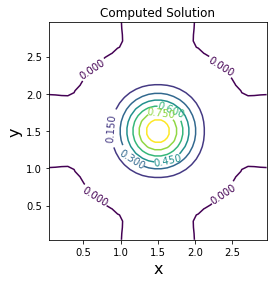

In [237]:
none, none, enorm = solve(36,36,"central","ilu",1)
print "Norm = ",enorm

## Grid Convergence Study
Perform a quantitative analysis of the error. Using multiple grids and compare the L2 norm reduction. 

In [238]:
#set up a sequence of grids
ngrids = 4
n = [16,32,64,128]
delta = np.zeros(ngrids)
l2 = np.zeros(ngrids)
nr = np.array(n, dtype=np.float64)  # make this real for plotting

# perform the simulations on each grid with different FD schemes
for ig in range(ngrids):
    delta[ig] = L_x/(float)(n[ig])
    none, none, l2[ig] = solve(n[ig],n[ig],"central","ilu",0)
    print "Grid ",ig," Delta = ",delta[ig]," Error =",l2[ig]

Completed ILU Iteration  40 Residual  6.95420643283e-09
Grid  0  Delta =  0.1875  Error = 0.0180213577071
Completed ILU Iteration  80 Residual  9.89095930059e-09
Grid  1  Delta =  0.09375  Error = 0.00437912194418
Completed ILU Iteration  99 Residual  7.03400898703e-05
Grid  2  Delta =  0.046875  Error = 0.00108713312789
Completed ILU Iteration  99 Residual  0.00199565619122
Grid  3  Delta =  0.0234375  Error = 0.000270582510337


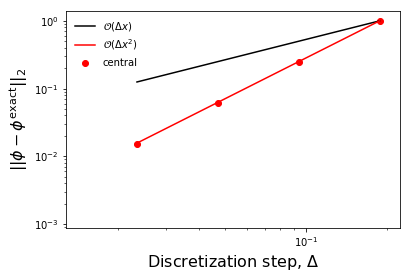

In [239]:
# plot the classical convergence diagram with first & second order slopes
pl.clf()
pl.scatter(delta, l2/l2[0],color="r", label="central")
pl.plot(delta,(delta/delta[0]),color="k",label=r"$\mathcal{O}(\Delta x)$")
pl.plot(delta,((delta/delta[0])**2),color="r",label=r"$\mathcal{O}(\Delta x^2)$")
ax = pl.gca()
ax.set_xscale('log')
ax.set_yscale('log')
pl.xlabel(r"Discretization step, $\Delta$",fontsize=16)
pl.ylabel(r"$\|| \phi - \phi^\mathrm{exact} \||_2$",fontsize=16)
pl.legend(frameon=False);

## Further work

Implement a Neumann boundary condition (based on the exact solution) on the $y=0$ boundary